# OSM 2024 figures notebook

***

In [1]:
import numpy as np
import xarray as xr
import yaml
import sys
from fastjmd95 import rho
from matplotlib import pyplot as plt, patches, colors
from cartopy import crs, feature
from datetime import datetime
from tqdm import tqdm

from shapely.geometry import Polygon
from shapely.ops import unary_union

# Import modules from path
sys.path.append('../modules/')
import calc_transformation_budget as trtools
import watermasstools as wmttools

plt.rcParams.update({'font.size': 13, 'axes.titlesize': 'medium'})

***

### AMOC figures

In [2]:
# Init dict
MHT = {'obs': {'lat': np.arange(-33.5, 64.51, 1)}, 'LR': {}, 'HR': {}}

# Load Trenberth et al. 2019 MHT
filename = '/pscratch/sd/b/bmoorema/data/Fig_12a_2000_2016_monthly_ZonalSum_AtlanticArctic_0-2000m_ensemble_mean.txt'
years = np.arange(2000, 2016)
mht = []
with open(filename) as f:
    for k in range(2):
        _ = f.readline()
    for year in range(2000, 2016):
        line = f.readline()
        values = [[float(val) for val in f.readline().split(None)] for lat in MHT['obs']['lat']]
        mht.append(values)
mht = np.array(mht)
MHT['obs']['mean'] = mht.mean(axis=(0, 2))
MHT['obs']['iqr'] = [np.percentile(mht, p, axis=(0, 2)) for p in (25, 75)]

# Load calculated MHT
for meshName in ['LR', 'HR']:
    ds = xr.open_dataset(f'/pscratch/sd/b/bmoorema/results/aggregated/mht/MHT_{meshName}_19972007.nc')
    mht = ds.meanMHT.values
    MHT[meshName]['lat'] = ds.latbins.values
    MHT[meshName]['mean'] = mht.mean(axis=0)
    MHT[meshName]['iqr'] = [np.percentile(mht, p, axis=0) for p in (25, 75)]

In [3]:
# Load MOC streamfunction Atlantic subregion from LR and HR results archive
MOC = {'LR': {}, 'HR': {}}
for meshName in MOC:

    # Get paths
    with open(f'../yaml/paths_{meshName}.yaml') as f:
        paths = yaml.safe_load(f)

    # Get bottom depth array
    with xr.open_dataset(paths['meshfile']) as ds:
        MOC[meshName]['refBottomDepth'] = ds.refBottomDepth.values

    # Loop through decades
    for decade in [('1947-1957'), ('1957-1967'), ('1997-2007')]:

        # Startyear and results prefix string
        startyear = int(decade.split('-')[0]) - 1946
        resultsprefix = paths['results'][decade] + '/' + paths['prefix']

        # Loop through years and months
        MOC[meshName][decade], latitude = {'MOC': []}, None
        for year in tqdm(range(startyear, startyear+10), desc=f'Loading {meshName} over {decade}'):
            for month in range(1, 13):

                # Open results file
                try:
                    with xr.open_dataset(resultsprefix + f'.{year:04d}-{month:02d}-01.nc') as ds:

                        if latitude is None:
                            MOC[meshName][decade]['lat'] = np.rad2deg(ds.binBoundaryMocStreamfunction.values)

                        MOC[meshName][decade]['MOC'].append(ds.timeMonthly_avg_mocStreamvalLatAndDepthRegion[0, 0, ...])
                except:
                    nan = np.full(MOC[meshName][decade]['MOC'][-1].shape, np.nan)
                    MOC[meshName][decade]['MOC'].append(nan)
        
        # Concatenate lists
        MOC[meshName][decade]['MOC'] = np.array(MOC[meshName][decade]['MOC'])

Loading HR over 1997-2007: 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


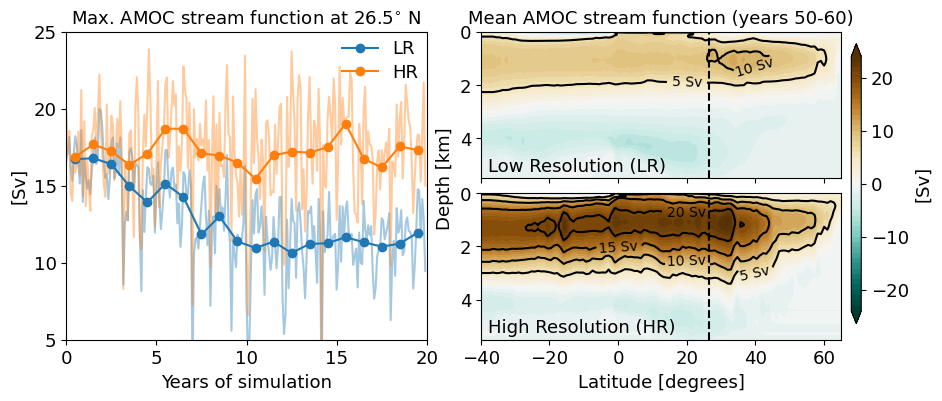

In [6]:
# Make figure layout
fig = plt.figure(figsize=(10, 4))
gs = plt.GridSpec(2, 2, hspace=0.1, wspace=0.15)
ax_left = fig.add_subplot(gs[:, 0])
axs = [fig.add_subplot(gs[row, 1]) for row in range(2)]
#ax_right = fig.add_subplot(gs[:, 2])
palette = plt.get_cmap('tab10').colors
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}

# Left panel timeseries
ax = ax_left
ax.set_xlim(0, 20)
ax.set_ylim(5, 25)
ax.yaxis.set_ticks([5, 10, 15, 20, 25])
ax.set_xlabel('Years of simulation')
ax.set_ylabel('[Sv]')
ax.set_title('Max. AMOC stream function at 26.5$^{\\circ}$ N')
#ax.text(0.02, 0.93, '(a)', transform=ax.transAxes)
julys = np.arange(6, 240, 12)
decade = '1947-1957'
for meshName, color in zip(['LR', 'HR'], palette):
    y = []
    for decade in ['1947-1957', '1957-1967']:
        ilat = abs(MOC[meshName][decade]['lat'] - 26.5).argmin()
        y.append(MOC[meshName][decade]['MOC'][..., ilat].max(axis=1))
    y = np.hstack(y)
    y_ann = [np.nanmean(y[jul-6:jul+6]) for jul in julys]
    ax.plot(np.arange(len(y))/12, y, color=color, alpha=0.4, zorder=0)
    ax.plot(julys/12, y_ann, 'o-', color=color, label=meshName, zorder=1)
ax.legend(loc=1, borderpad=0.3, borderaxespad=0.15, labelspacing=0.3, frameon=False)

# Middle panels AMOC
decade = '1997-2007'
ylim = [5.5, 0]
loc_list = [[(40, 1.5), (20, 2)], [(20, 1), (0, 2), (20, 2.5), (40, 3)]]
for ax, meshName, label, locs in zip(axs, ['LR', 'HR'], ['Low Resolution (LR)', 'High Resolution (HR)'], loc_list):
    x, y, z = MOC[meshName][decade]['lat'], MOC[meshName]['refBottomDepth']*1e-3, MOC[meshName][decade]['MOC']
    c = ax.contourf(x, y, z.mean(axis=0), levels=np.arange(-24, 25), cmap='BrBG_r', extend='both')
    cs = ax.contour(x, y, z.mean(axis=0), levels=[5, 10, 15, 20], colors='k')
    ax.plot([26.5, 26.5], ylim, 'k--')
    ax.set_xlim([-40, 65])
    ax.set_ylim(ylim)
    ax.text(0.02, 0.05, label, transform=ax.transAxes)
    ax.clabel(cs, inline=1, manual=locs, fontsize=10, fmt='%d Sv')
axs[0].set_title(f'Mean AMOC stream function (years 50-60)')
axs[0].xaxis.set_ticklabels('')
axs[1].set_xlabel('Latitude [degrees]')
axs[1].set_ylabel('Depth [km]', y=1.1)
#axs[0].text(0.025, 0.86, '(b)', transform=axs[0].transAxes, bbox=props)
cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='[Sv]', ticks=[-20, -10, 0, 10, 20])

# Right panel MHT
#ax = ax_right
#pos = ax.get_position()
#ax.set_position([pos.x0+0.01, pos.y0, pos.width, pos.height])
#ax.set_xlim(-33.5, 64.5)
#ax.set_ylim(0, 1.8)
#ax.set_xlabel('Latitude [degrees]')
#ax.set_ylabel('[PW]')
#ax.set_title('Meridional heat transport 1998-2008')
#ax.text(0.02, 0.93, '(c)', transform=ax.transAxes)
#for meshName, color in zip(['obs', 'LR', 'HR'], ['g'] + list(palette)):
#    label = 'Trenberth et al. 2019' if meshName == 'obs' else meshName
#    ax.plot(MHT[meshName]['lat'], MHT[meshName]['mean'], color=color, label=label)
#    ax.fill_between(MHT[meshName]['lat'], *MHT[meshName]['iqr'], fc=color, ec=color, alpha=0.2)
#ax.legend(loc=1, markerfirst=False, frameon=False, borderpad=0.3, borderaxespad=0.15, labelspacing=0.3)

fig.savefig('/pscratch/sd/b/bmoorema/posterfigs2/AMOC.pdf', bbox_inches='tight')

***

### Bias figures

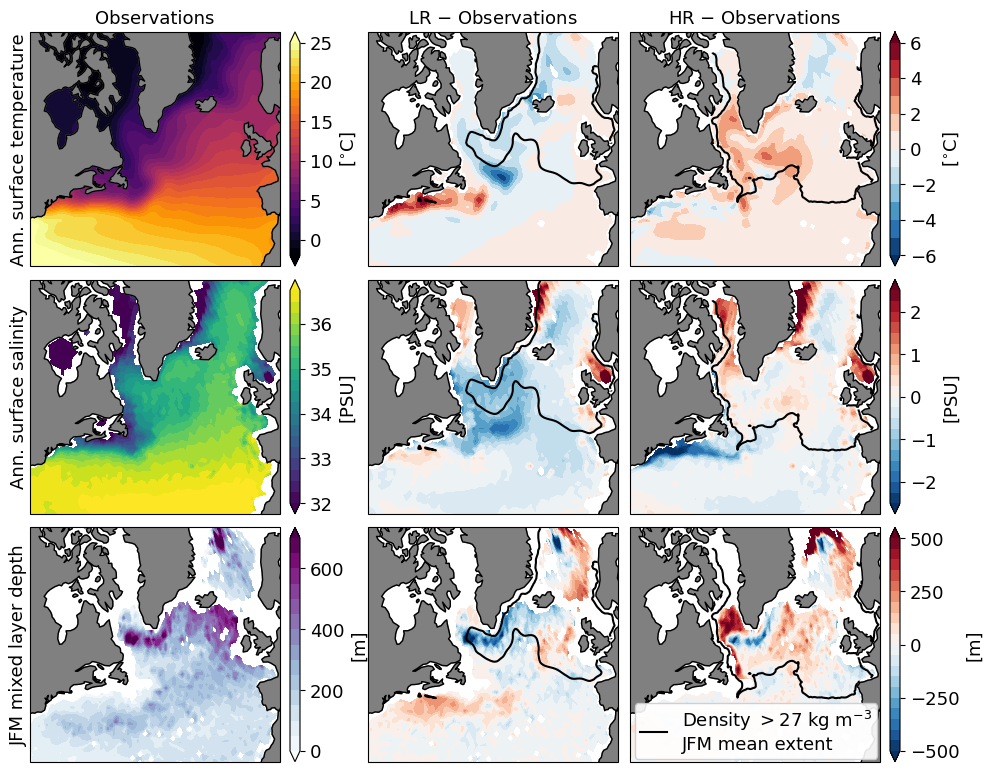

In [15]:
obspath = '/global/cfs/cdirs/e3sm/diagnostics/observations/Ocean/'
mpaspath = '/pscratch/sd/b/bmoorema/results/aggregated/lonlat/'

meshNames = ['EC30to60E2r2', 'oRRS18to6v3']
obsnames = ['SST', 'SSS', 'mld_dt_mean']
obsfilenames = [
    'SST/MODEL.SST.HAD187001-198110.OI198111-201203.nc',
    'SSS/Aquarius_V3_SSS_Monthly.nc',
    'MLD/holtetalley_mld_climatology.nc',
]
mpasnames = ['temperature', 'salinity', 'dThreshMLD']
units = ['[$^{\\circ}$C]', '[PSU]', '[m]']
cmaps = ['inferno', 'viridis', 'BuPu']
clims = [(-2, 26, 1, 6), (32, 36.8, 0.25, 2.5), (0, 701, 50, 500)]
cticks = [(0, 26, 5, 6, 2), (32, 36.1, 1, 2, 1), (0, 701, 200, 500, 250)]

# Make map figure
decade = '19970101_20061231'
proj, proj_ref = crs.LambertConformal(-40, 40), crs.PlateCarree()
fig, axs = plt.subplots(3, 3, figsize=(10, 9.5), subplot_kw={'projection': proj}, gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}

# Add titles and labels
labels = ['Ann. surface temperature', 'Ann. surface salinity', 'JFM mixed layer depth']
titles = ['Observations', 'LR $-$ Observations', 'HR $-$ Observations']
for row, col, title, label in zip(axs[:, 0], axs[0, :], titles, labels):
    col.set_title(title)
    row.text(-0.08, 0.5, label, va='center', rotation=90, transform=row.transAxes)

# Loop through variables
iterables = [axs, obsnames, obsfilenames, mpasnames, cmaps, clims, cticks, units]
for row, obsname, obsfilename, mpasname, cmap, clim, ctick, unit in zip(*iterables):
    
    filename = obspath + obsfilename
    with xr.open_dataset(filename) as ds:
        lons, lats = ds.lon.values, ds.lat.values
        variable_obs = ds[obsname]
    if obsname == 'SST':
        variable_obs = variable_obs.mean(dim='time').values #.sel(time=slice(*decade.split('_')))
        ilon = np.where(lons > 180)[0][0]
        variable_obs = np.hstack([variable_obs[:, ilon:], variable_obs[:, :ilon]])
        lons = np.hstack([lons[ilon:]-360, lons[:ilon]])
    elif obsname == 'mld_dt_mean':
        variable_obs = variable_obs.isel(iMONTH=[0, 1, 2]).mean(dim='iMONTH').values
    else:
        variable_obs = variable_obs.mean(dim='time').values
    c = row[0].contourf(lons, lats, variable_obs, cmap=cmap, levels=np.arange(*clim[:3]), extend='both', transform=proj_ref, zorder=-10)
    row[0].set_extent([-75, -10, 25, 78])
    row[0].coastlines()
    row[0].add_feature(feature.LAND, color='gray')
    pos = row[0].get_position()
    row[0].set_position([pos.x0-0.075, pos.y0, pos.width, pos.height])
    cax = fig.add_axes([pos.x1-0.065, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax, label=unit, ticks=np.arange(*ctick[:3]))
    
    # Loop through meshes
    for ax, meshName in zip(row[1:], meshNames):

        filename = mpaspath + f'20210421_sim7_CORE_{meshName}.mpas2Dtimeavg_wmt_{decade}.nc'
        levels = np.arange(-clim[3], clim[3]+clim[2], clim[2])
        with xr.open_dataset(filename) as ds:
            lon, lat = ds.lon.values, ds.lat.values
            variable = ds[mpasname]
            sigma = ds.sigmaTheta
        if 'depths' in variable.dims:
            variable = variable.isel(depths=0)
        if mpasname == 'dThreshMLD':
            variable = variable.sel(months=variable.months.isin([1, 2, 3]))
        variable = variable.mean(dim='months', skipna='False')
        variable = variable.interp(lon=lons, lat=lats)
        c = ax.contourf(lons, lats, variable-variable_obs, cmap='RdBu_r', levels=levels, extend='both', transform=proj_ref)
        sigma = sigma.sel(months=sigma.months.isin([1, 2, 3])).mean(dim='months', skipna='False')
        ax.contour(sigma.lon, sigma.lat, sigma, levels=[27], colors='k', transform=proj_ref)
        ax.set_extent([-75, -10, 25, 78])
        ax.coastlines()
        ax.add_feature(feature.LAND, color='gray')
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.01, pos.y0, 0.01, pos.height])
    fig.colorbar(c, cax=cax, label=unit, ticks=np.arange(-ctick[3], ctick[3]+ctick[4], ctick[4]))

# Add sigma legend and panel labels
axs[2, 2].plot(0, 0, 'k-', label='Density $>27$ kg m$^{-3}$\nJFM mean extent')
axs[2, 2].legend(loc=4, handlelength=1.5, borderpad=0.3, borderaxespad=0.15, framealpha=0.9)
#for k, ax in enumerate(axs.ravel()):
#    ax.text(0.03, 0.93, f'({chr(97+k)})', transform=ax.transAxes, color='w') #bbox=props)
fig.savefig('/pscratch/sd/b/bmoorema/posterfigs2/biases.pdf', bbox_inches='tight')

### 2D transformation plots

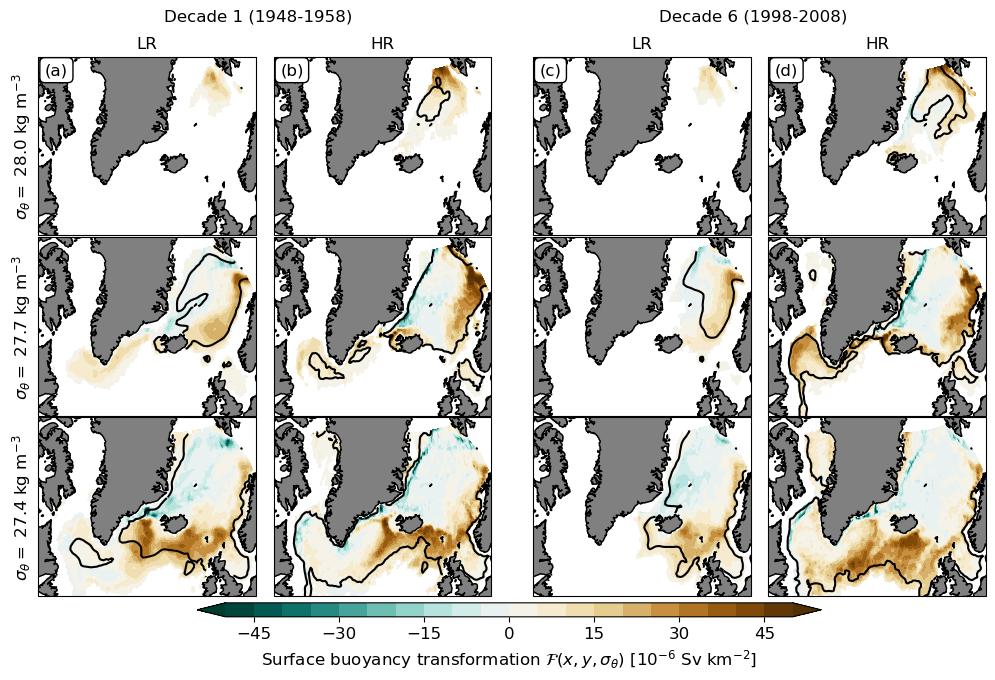

In [56]:
# Make map figure
decade = '19470101_19561231'
proj, proj_ref = crs.LambertConformal(-20, 70), crs.PlateCarree()
fig, axs = plt.subplots(3, 4, figsize=(12, 7), subplot_kw={'projection': proj}, gridspec_kw={'hspace': 0.01, 'wspace': 0.05})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}

meshes = ['EC30to60E2r2', 'oRRS18to6v3']
for panels, decade in zip([axs[:, :2], axs[:, 2:]], ['19470101_19561231', '19970101_20061231']):
    for col, mesh, meshName in zip(panels.T, meshes, ['LR', 'HR']):
        f = f'/pscratch/sd/b/bmoorema/results/aggregated/lonlat/20210421_sim7_CORE_{mesh}.mpas2Dtimeavg_wmt_{decade}.nc'
        ds = xr.open_dataset(f)
        col[0].set_title(meshName)
        for ax, sigmaBin in zip(col, [28.0, 27.7, 27.4]):
            sigmaJFM = ds.sigmaTheta.max(dim='months') # .sel(months=ds.months.isin([1, 2, 3]))
            wmt = ds.totalTrans.sel(sigmaBins=sigmaBin).mean(dim='months')
            wmt = wmt.where(wmt!=0)
            c = ax.contourf(ds.lon, ds.lat, wmt, cmap='BrBG_r', levels=np.arange(-50, 51, 5), extend='both', transform=proj_ref)
            ax.contour(ds.lon, ds.lat, sigmaJFM, levels=[sigmaBin], colors='k', transform=proj_ref)
            ax.set_extent([-60, 5, 50, 79])
            ax.coastlines(resolution='50m')
            ax.add_feature(feature.LAND, color='gray')
            pos = ax.get_position()
            if decade == '19470101_19561231':
                ax.set_position([pos.x0-0.01, pos.y0, pos.width, pos.height])
                if meshName == 'LR':
                    ax.text(-0.13, 0.5, f'$\\sigma_{{\\theta}} = $ {sigmaBin:0.1f} kg m$^{{-3}}$', va='center', rotation=90, transform=ax.transAxes)
            else:
                ax.set_position([pos.x0+0.01, pos.y0, pos.width, pos.height])

axs[0, 0].text(1.01, 1.2, 'Decade 1 (1948-1958)', ha='center', transform=axs[0, 0].transAxes)
axs[0, 2].text(1.01, 1.2, 'Decade 6 (1998-2008)', ha='center', transform=axs[0, 2].transAxes)
for k, ax in enumerate(axs[0, :]):
    ax.text(0.03, 0.9, f'({chr(97+k)})', transform=ax.transAxes, bbox=props)
cax = fig.add_axes([0.25, 0.08, 0.52, 0.02])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Surface buoyancy transformation $\\mathcal{F}(x,y,\\sigma_{\\theta})$ [10$^{-6}$ Sv km$^{-2}$]')
#fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/transformation2D.pdf', bbox_inches='tight')

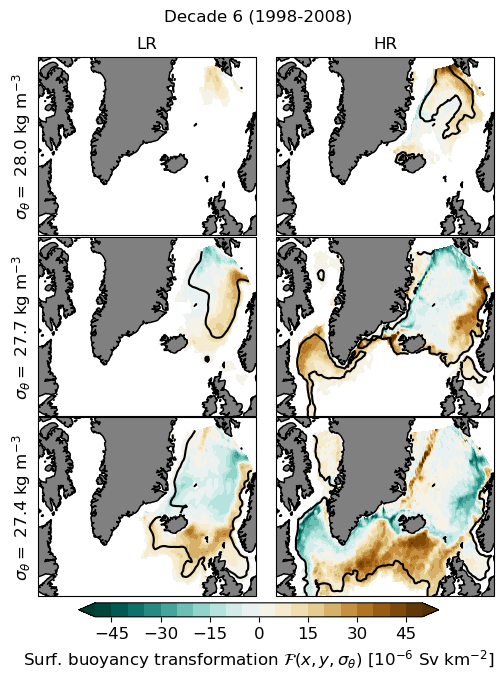

In [11]:
# Make map figure
decade = '19970101_20061231'
proj, proj_ref = crs.LambertConformal(-20, 70), crs.PlateCarree()
fig, axs = plt.subplots(3, 2, figsize=(6, 7), subplot_kw={'projection': proj}, gridspec_kw={'hspace': 0.01, 'wspace': 0.05})
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}

meshes = ['EC30to60E2r2', 'oRRS18to6v3']
for col, mesh, meshName in zip(axs.T, meshes, ['LR', 'HR']):
    f = f'/pscratch/sd/b/bmoorema/results/aggregated/lonlat/20210421_sim7_CORE_{mesh}.mpas2Dtimeavg_wmt_{decade}.nc'
    ds = xr.open_dataset(f)
    col[0].set_title(meshName)
    for ax, sigmaBin in zip(col, [28.0, 27.7, 27.4]):
        sigmaJFM = ds.sigmaTheta.max(dim='months') # .sel(months=ds.months.isin([1, 2, 3]))
        wmt = ds.totalTrans.sel(sigmaBins=sigmaBin).mean(dim='months') - ds.totalTrans.sel(sigmaBins=sigmaBin+0.3,method='nearest').mean(dim='months')
        wmt = wmt.where(wmt!=0)
        c = ax.contourf(ds.lon, ds.lat, wmt, cmap='BrBG_r', levels=np.arange(-50, 51, 5), extend='both', transform=proj_ref)
        ax.contour(ds.lon, ds.lat, sigmaJFM, levels=[sigmaBin], colors='k', transform=proj_ref)
        ax.set_extent([-60, 5, 50, 79])
        ax.coastlines(resolution='50m')
        ax.add_feature(feature.LAND, color='gray')
        pos = ax.get_position()
        if meshName == 'LR':
            ax.text(-0.13, 0.5, f'$\\sigma_{{\\theta}} = $ {sigmaBin:0.1f} kg m$^{{-3}}$', va='center', rotation=90, transform=ax.transAxes)

axs[0, 0].text(1.01, 1.2, 'Decade 6 (1998-2008)', ha='center', transform=axs[0, 0].transAxes)
cax = fig.add_axes([0.2, 0.08, 0.6, 0.02])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Surf. buoyancy transformation $\\mathcal{F}(x,y,\\sigma_{\\theta})$ [10$^{-6}$ Sv km$^{-2}$]')
#fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/transformation2D_decade6.pdf', bbox_inches='tight')

### Transect plots

In [17]:
transect = {'OSNAP East Irminger': {}, 'OSNAP East Iceland': {}, 'Iceland-Scotland': {}}

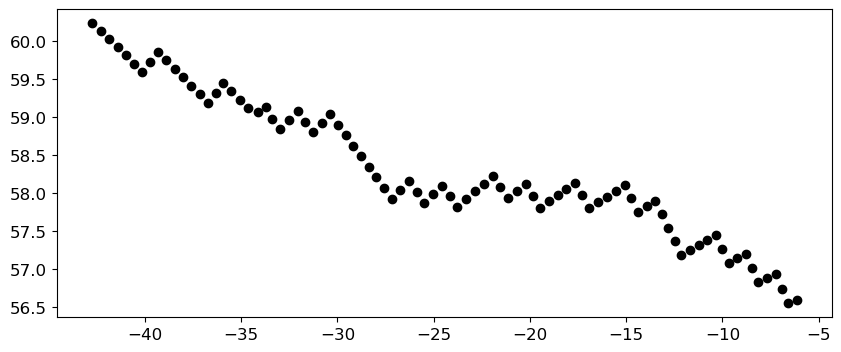

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(lonEdge, latEdge, 'ko')

In [21]:
meshName = 'LR'
#transectName = 'Iceland-Scotland'
transectName = 'OSNAP East'
portion = ' Iceland'

# Get paths
with open(f'../yaml/paths_{meshName}.yaml') as f:
    paths = yaml.safe_load(f)

# Load coords
coords, transectMasks, subdomain = trtools.load_coords(paths)
index, sign = [transectMasks[transectName][name] for name in ('index', 'sign')]
lonEdge, latEdge, dvEdge = [coords[name][index] for name in ('lonEdge', 'latEdge', 'dvEdge')]

# Grab Irminger Basin only
idx = lonEdge > -35
index, sign, lonEdge, dvEdge = index[idx], sign[idx], lonEdge[idx], dvEdge[idx]

# Continue ...
ilon = np.argsort(lonEdge)
index, sign, dvEdge = [var[ilon] for var in (index, sign, dvEdge)]
lonVertex = coords['lonVertex']
cellsOnEdge, verticesOnEdge = [coords[name][index, :] for name in ('cellsOnEdge', 'verticesOnEdge')]
lons = [lonVertex[vertex].min() for vertex in verticesOnEdge]
lons.append(lonVertex[verticesOnEdge[-1, :]].max())
depths = np.insert(coords['depth'], 0, 0)

# Loop through decades
startyear = 1946
decade = (1947, 1957)

# Define results path
decade_str = str(decade[0]) + '-' + str(decade[1])
resultspath = paths['results'][decade_str] + '/' + paths['prefix']

# Define times
times = [datetime(year, month, 1) for year in range(*decade) for month in range(1, 13)]

In [22]:
# Loop through times
sigma, thickness, velocity = [], [], []
wmt, n = [], len(times)
for t in tqdm(times):

    # Load results
    filename = resultspath + f'.{t.year-startyear:04d}-{t.month:02d}-01.nc'
    with xr.open_dataset(filename) as ds:

        # Get sigma
        sigmaTheta = ds.timeMonthly_avg_potentialDensity[0, ...].values[subdomain, :] - 1000
        sigma.append(trtools.interpolate_to_edge(sigmaTheta, cellsOnEdge, subdomain))
        
        # Get layer thickness
        layerThickness = ds.timeMonthly_avg_layerThickness[0, ...].values[subdomain, :]
        thickness.append(trtools.interpolate_to_edge(layerThickness, cellsOnEdge, subdomain))
        
        # Get velocity
        velocity.append(ds.timeMonthly_avg_normalVelocity[0, index, :].values * sign[:, None])

100%|██████████| 120/120 [00:23<00:00,  5.05it/s]


In [23]:
sigma, thickness, velocity = [np.array(var) for var in (sigma, thickness, velocity)]
mask = velocity == 0
sigma[mask], thickness[mask], velocity[mask] = np.nan, np.nan, np.nan
transport = velocity * thickness * dvEdge[None, :, None] * 1e-6
transect[transectName + portion][meshName] = {
    'lons': lons, 'depths': depths, 'sigma': sigma, 'velocity': velocity, 'transport': transport,
}

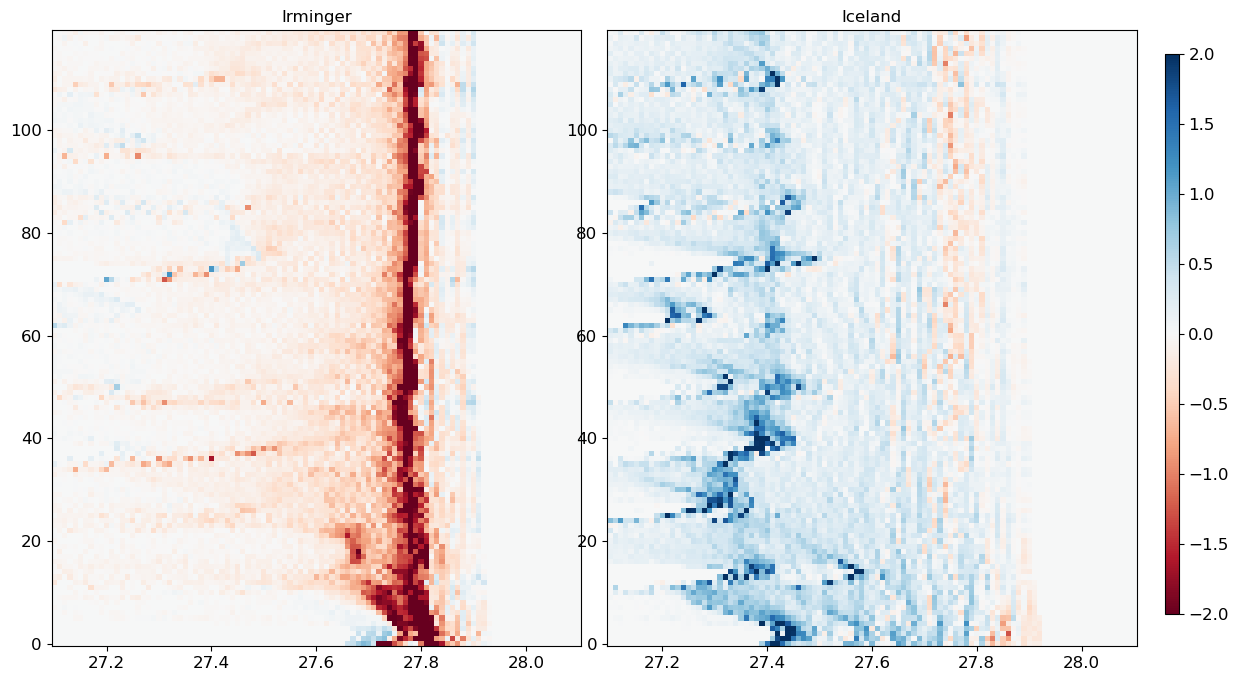

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'wspace': 0.05})
binsize = 0.01
sigmabins = np.arange(27.1, 28.11, binsize)

for ax, portion in zip(axs, ['Irminger', 'Iceland']):
    sigma, transport = [transect['OSNAP East ' + portion]['LR'][name] for name in ('sigma', 'transport')]
    trans = []
    for sbin in sigmabins:
        index = (sigma > sbin) & (sigma <= sbin + binsize)
        trans.append(np.ma.masked_where(~index, transport).sum(axis=(1, 2)).data)
    trans = np.array(trans).T
    c = ax.pcolormesh(sigmabins, range(120), trans, vmin=-2, vmax=2, cmap='RdBu')
    ax.set_title(portion)

cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax)

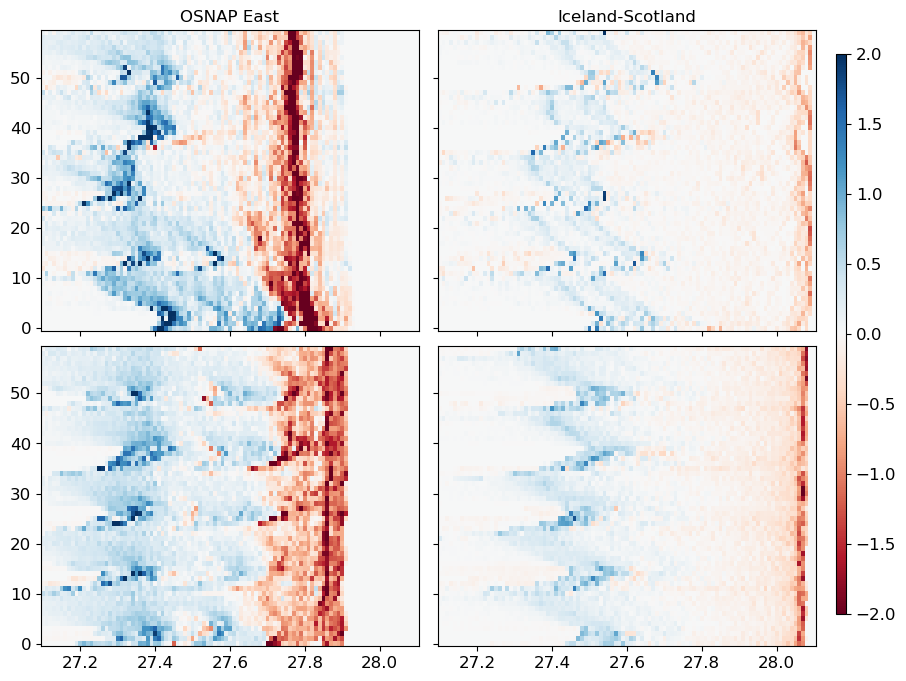

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
binsize = 0.01
sigmabins = np.arange(27.1, 28.11, binsize)

for row, meshName in zip(axs, ['LR', 'HR']):
    
    for ax, transectName in zip(row, ['OSNAP East', 'Iceland-Scotland']):

        sigma, transport = [transect[transectName][meshName][name] for name in ('sigma', 'transport')]
        trans = []
        for sbin in sigmabins:
            index = (sigma > sbin) & (sigma <= sbin + binsize)
            trans.append(np.ma.masked_where(~index, transport).sum(axis=(1, 2)).data)
        trans = np.array(trans).T
        c = ax.pcolormesh(sigmabins, range(60), trans, vmin=-2, vmax=2, cmap='RdBu')
        if meshName == 'LR':
            ax.xaxis.set_ticklabels('')
            ax.set_title(transectName)
        if transectName == 'Iceland-Scotland':
            ax.yaxis.set_ticklabels('')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax)

In [114]:
results_path = '/pscratch/sd/b/bmoorema/results/aggregated/transformation/'
wmt = {}
for meshName in ['LR', 'HR']:
    wmt[meshName] = xr.open_dataset(results_path + f'transformationbudget_{meshName}_1947-1957.nc')

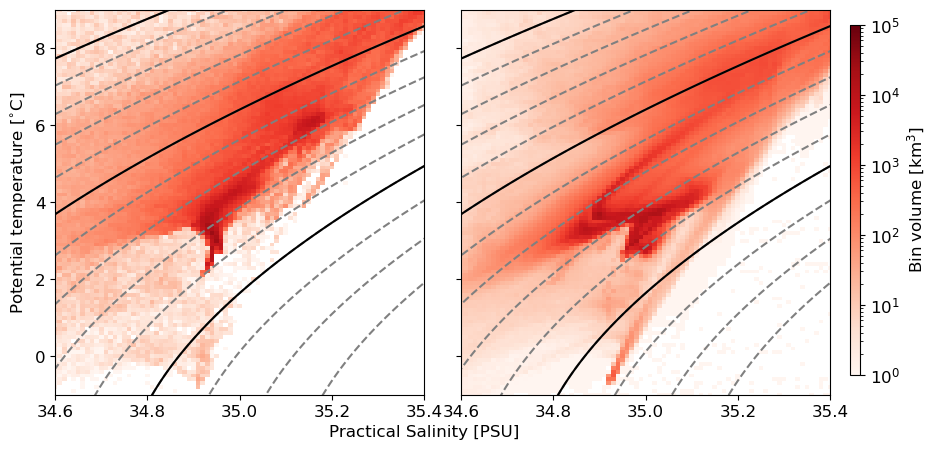

In [129]:
S, T = [wmt['LR'][name] for name in ('salinityBins', 'temperatureBins')]
Sgrid, Tgrid = np.meshgrid(S, T)
sigma = rho(Sgrid, Tgrid, 0) - 1000

# Make figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.1})
xlim, ylim = [34.6, 35.4], [-1, 9]
axs[0].set_xlabel('Practical Salinity [PSU]', x=1)
axs[0].set_ylabel('Potential temperature [$^{\circ}$C]')

for ax, meshName in zip(axs, ['LR', 'HR']):

    # Plot volume and density
    volume = wmt[meshName].volumetricTS.sel(regionNames='Irminger Iceland Rockall')
    c = ax.pcolormesh(S, T, volume[12:60, ...].mean(axis=0), cmap='Reds', norm=colors.LogNorm(vmin=1, vmax=1e5))
    ax.contour(S, T, sigma, levels=np.arange(27, 28.3, 0.1), colors='gray', linestyles='--')
    ax.contour(S, T, sigma, levels=[27, 27.5, 28], colors='k', linestyles='-')

    # Formatting
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

axs[1].yaxis.set_ticklabels('')
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Bin volume [km$^{3}$]')

In [17]:
sigma, thickness, velocity = [np.array(var).mean(axis=0).T for var in (sigma, thickness, velocity)]
mask = velocity == 0
sigma[mask], thickness[mask], velocity[mask] = np.nan, np.nan, np.nan
transport = velocity * thickness * dvEdge[None, :] * 1e-6
transect[meshName] = {
    'lons': lons, 'depths': depths, 'sigma': sigma, 'velocity': velocity, 'transport': transport,
}

In [18]:
def pcolor_threshold_polygons(x, y, z, threshold):
    """
    """

    # Build shapely polygons from sigma threshold
    rectangles = []
    for j, i in zip(*np.where(z >= threshold)):
        x0, x1, y0, y1 = x[i], x[i+1], y[j], y[j+1]
        rectangles.append(Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]))
    polygons = unary_union(rectangles)

    # Shapely will return either a Polygon or a MultiPolygon. 
    # Make sure the structure is the same in any case.
    if polygons.geom_type == 'Polygon':
        polygons = [polygons]
    else:
        polygons = polygons.geoms
    
    return polygons

/tmp/ipykernel_183293/1989745948.py:61: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, cax=cax, orientation='horizontal', label='Transect normal velocity [m s$^{-1}$]')


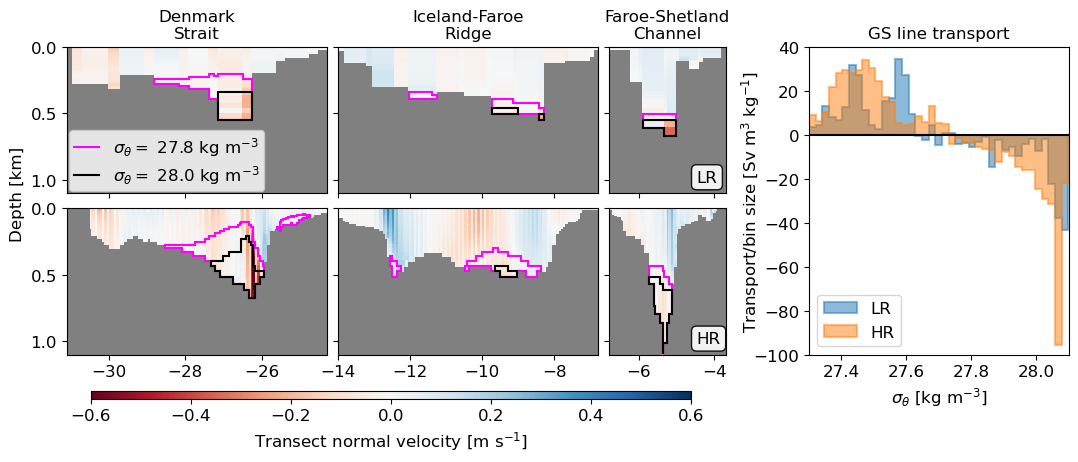

In [53]:
# Make figure layout
fig = plt.figure(figsize=(12, 4))
gs = plt.GridSpec(2, 4, wspace=0.05, hspace=0.1, width_ratios=[1, 1, 0.45, 1])
axs = np.array([[fig.add_subplot(gs[row, col]) for col in range(3)] for row in range(2)])
ax_right = fig.add_subplot(gs[:, 3])
pos = ax_right.get_position()
ax_right.set_position([pos.x0+0.06, pos.y0, pos.width, pos.height])
axs[1, 0].set_ylabel('Depth [km]', y=1.1)
xlims, ylim = [(-31.1, -24.3), (-14, -6.8), (-6.8, -3.7)], [1.1, 0]
xticks = [(-30, -25), (-14, -7), (-6, -3)]
names = ['Denmark\nStrait', 'Iceland-Faroe\nRidge', 'Faroe-Shetland\nChannel']
props = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}

# Plot section velocity and sigma
for row, meshName in zip(axs, ['LR', 'HR']):
    lons, depths, sigma, velocity = [transect[meshName][name] for name in ('lons', 'depths', 'sigma', 'velocity')]
    depths = depths * 1e-3
    polygons = {threshold: pcolor_threshold_polygons(lons, depths, sigma, threshold) for threshold in [27.8, 28]}
    for ax, name, xlim, xtick in zip(row, names, xlims, xticks):
        ax.add_patch(patches.Rectangle((xlim[0], ylim[0]), float(np.diff(xlim)), float(np.diff(ylim)), fc='gray'))
        c = ax.pcolor(lons, depths, velocity, cmap='RdBu', vmin=-0.6, vmax=0.6, shading='flat', lw=0.1)
        c.set_edgecolor('face')
        for threshold, color in zip([27.8, 28], ['magenta', 'k']):
            for polygon in polygons[threshold]:
                ax.add_patch(patches.Polygon(polygon.exterior.coords, fc='none', ec=color, lw=1.5))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_ticks(np.arange(*xtick, 2))
        ax.yaxis.set_ticks([0, 0.5, 1])

        if meshName == 'LR':
            ax.xaxis.set_ticklabels('')
            ax.set_title(name)
        if name == 'Faroe-Shetland\nChannel':
            ax.text(0.75, 0.08, meshName, transform=ax.transAxes, bbox=props)
        if name != 'Denmark\nStrait':
            ax.yaxis.set_ticklabels('')

# Plot transport histogram
ax = ax_right
palette = plt.get_cmap('tab10').colors
xlim, ylim, binsize = [27.3, 28.14], [-100, 40], 0.02
bins = int(np.diff(xlim) / binsize)
for meshName, color, zorder in zip(['LR', 'HR'], palette, [1, 0]):
    sigma, transport = [transect[meshName][name] for name in ('sigma', 'transport')]
    _, _, _ = ax.hist(
        sigma.ravel(), range=xlim, bins=bins, weights=transport.ravel() / binsize,
        ec=color, alpha=0.5, lw=1.5, fill=True, histtype='step', label=meshName,
    )
ax.plot(xlim, [0, 0], 'k-')
ax.set_xlim([27.3, 28.1])
ax.set_ylim(ylim)
ax.yaxis.set_label_coords(-0.18, 0)
ax.set_xlabel('$\\sigma_{\\theta}$ [kg m$^{-3}$]')
ax.set_ylabel('Transport/bin size [Sv m$^{3}$ kg$^{-1}$]')
ax.set_title('GS line transport')
ax.legend(loc=3)

# Colorbar
cax = fig.add_axes([0.145, 0, 0.5, 0.02])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Transect normal velocity [m s$^{-1}$]')

# Fake legend
for threshold, color in zip([27.8, 28], ['magenta', 'k']):
    axs[0, 0].plot(0, 0, '-', color=color, label=f'$\\sigma_{{\\theta}} = $ {threshold:.1f} kg m$^{{-3}}$')
axs[0, 0].legend(loc=3, handlelength=1.5, labelspacing=0.3, borderpad=0.3, borderaxespad=0.15)
#fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/GStransect_19471949.pdf', bbox_inches='tight')